# Germany Car Accidents Analysis  

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [52]:
df = pd.read_excel('file/New_table.xlsx', sheet_name='Sheet1')
df.head(800)




,Year,Months,Location,Personal Injury Accidents,Serious Accidents (Material Damage),Other Accidents (Intoxication),Other Accidents (Material Damage),Total Accidents
0,2011,January,Inside built-up areas,10595.0,3893.0,970.0,114745.0,130203.0
1,2011,January,Outside built-up areas (excl. motorways/freeways),4995.0,2137.0,181.0,31161.0,38474.0
2,2011,January,On motorways/freeways,1250.0,1094.0,45.0,8985.0,11374.0
3,2011,January,Total,16840.0,7124.0,1196.0,154891.0,180051.0
4,2011,February,Inside built-up areas,11008.0,3548.0,889.0,105064.0,120509.0
...,...,...,...,...,...,...,...,...
667,2024,November,Total,20679.0,5773.0,1143.0,186199.0,213794.0
668,2024,December,Inside built-up areas,NaN,NaN,NaN,NaN,NaN
669,2024,December,Outside built-up areas (excl. motorways/freeways),NaN,NaN,NaN,NaN,NaN
670,2024,December,On motorways/freeways,NaN,NaN,NaN,NaN,NaN


In [53]:
df.columns

Index(['Year', 'Months', 'Location', 'Personal Injury Accidents',
       'Serious Accidents (Material Damage)', 'Other Accidents (Intoxication)',
       'Other Accidents (Material Damage)', 'Total Accidents'],
      dtype='object')

In [54]:
missing_values = df.isnull().sum()
print(missing_values)

Year                                   0
Months                                 0
Location                               0
Personal Injury Accidents              4
Serious Accidents (Material Damage)    4
Other Accidents (Intoxication)         4
Other Accidents (Material Damage)      4
Total Accidents                        4
dtype: int64


## 1. Annual Accident Trends by Location
- ### Classify accidents by year and location

In [55]:
# Group by year and location
accidents_by_year_location = (
    df.groupby(['Year', 'Location'])[['Total Accidents']]
    .sum()
    .unstack()
    .reset_index()
)

# Rename columns for better clarity
accidents_by_year_location = accidents_by_year_location.rename(columns={
    'Inside built-up areas': 'Urban',
    'On motorways/freeways': 'Highway',
    'Outside built-up areas (excl. motorways/freeways)': 'Non-urban'
})


print(accidents_by_year_location)



          Year Total Accidents                                
Location                 Urban    Highway Non-urban      Total
0         2011        893313.0  1457112.0  203357.0  3867488.0
1         2012       1751166.0   150943.0  499734.0  2401843.0
2         2013       1769104.0   152173.0  492734.0  2414011.0
3         2014       1789278.0   151794.0  465613.0  2406685.0
4         2015       1854919.0   161096.0  500816.0  2516831.0
5         2016       1903429.0   174067.0  507831.0  2585327.0
6         2017       1934538.0   178861.0  529699.0  2643098.0
7         2018       2002482.0   175995.0  514178.0  2636468.0
8         2019       2100324.0   177981.0  531842.0  2682144.0
9         2020       1803696.0   130131.0  469827.0  2198716.0
10        2021       1732590.0   140525.0  432274.0  2300669.0
11        2022       1611162.0   147397.0  400334.0  2219050.0
12        2023       1838802.0   165131.0  508966.0  2512899.0
13        2024       1687834.0   150728.0  449020.0  22

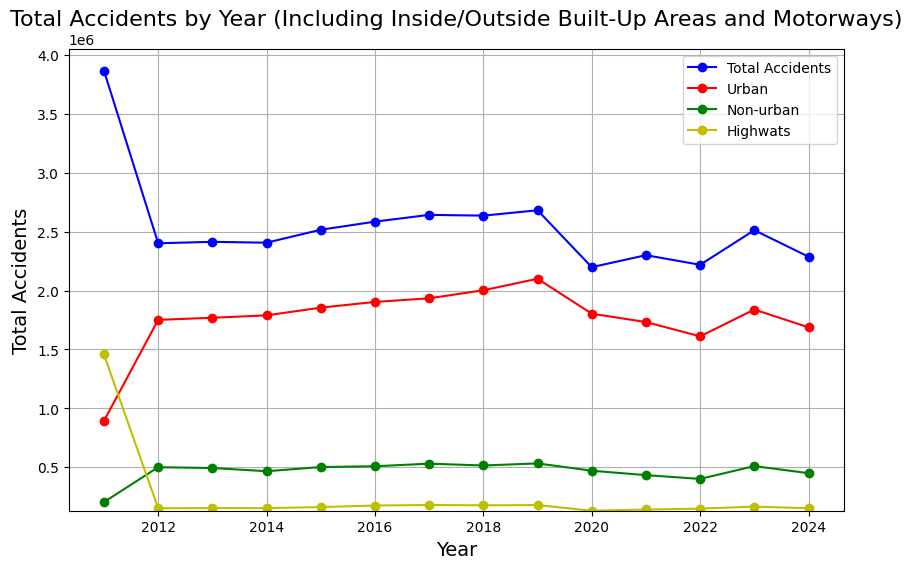

In [56]:
# Plotting the total accidents for each year
plt.figure(figsize=(10, 6))

# Plotting Total Accidents
plt.plot(total_by_year['Year'], total_by_year['Total Accidents'], marker='o', linestyle='-', color='b', label='Total Accidents')

# Plotting Inside Built-Up Areas
plt.plot(inside_built_up_areas['Year'], inside_built_up_areas['Total Accidents'], marker='o', linestyle='-', color='r', label='Urban')

# Plotting Outside Built-Up Areas
plt.plot(outside_built_up_areas['Year'], outside_built_up_areas['Total Accidents'], marker='o', linestyle='-', color='g', label='Non-urban')

# Plotting On Motorways
plt.plot(on_motorways['Year'], on_motorways['Total Accidents'], marker='o', linestyle='-', color='y', label='Highwats')

# Add labels, title, and legend
plt.title('Total Accidents by Year (Including Inside/Outside Built-Up Areas and Motorways)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Accidents', fontsize=14)

# Set the y-axis limit to start from 130,000
plt.ylim(130000, plt.ylim()[1])

# Add grid for better readability
plt.grid(True)

# Add legend to differentiate between the categories
plt.legend()

# Show the plot
plt.show()


- ### Objective: Analyze the distribution of accident types.

    Year  Personal Injury Accidents  Serious Accidents (Material Damage)  \
0   2011                  1807091.0                            1474432.0   
1   2012                   599274.0                             164294.0   
2   2013                   582210.0                             161648.0   
3   2014                   604870.0                             140958.0   
4   2015                   611318.0                             137552.0   
5   2016                   616290.0                             143276.0   
6   2017                   605312.0                             148922.0   
7   2018                   617442.0                             138322.0   
8   2019                   600286.0                             138378.0   
9   2020                   528998.0                             119944.0   
10  2021                   517974.0                             130247.0   
11  2022                   579344.0                             120485.0   
12  2023    

<Figure size 1200x700 with 0 Axes>

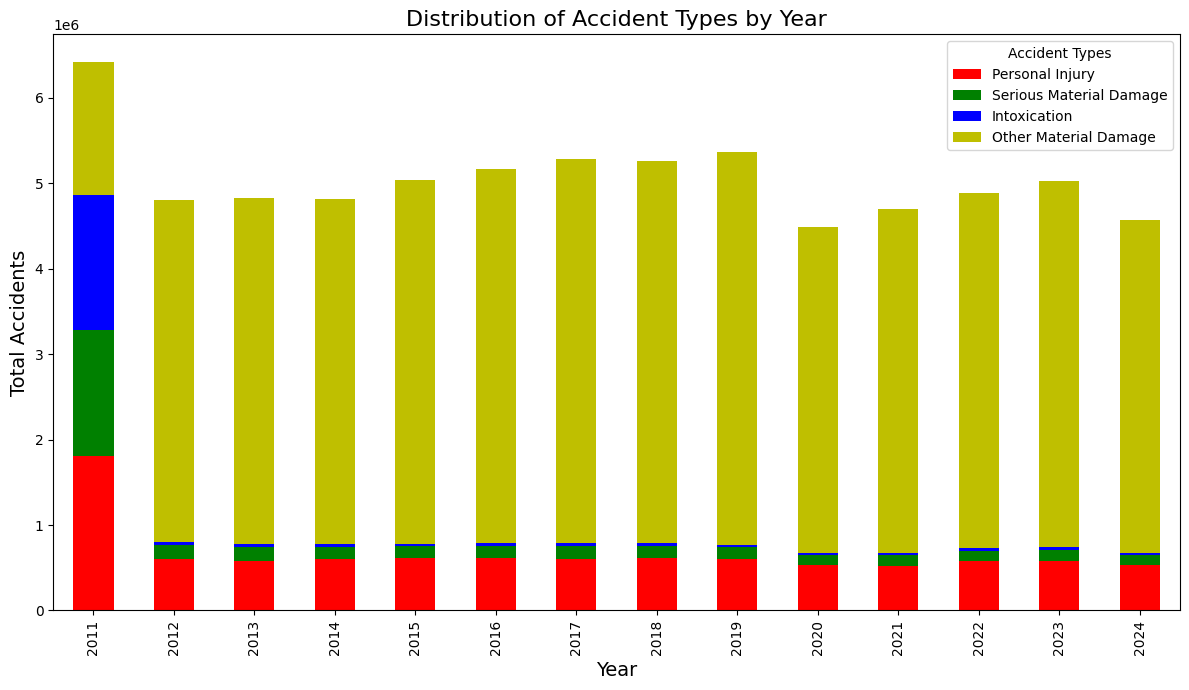

In [57]:
# Aggregate data by Year and accident type
accident_types = [
'Personal Injury Accidents', 
'Serious Accidents (Material Damage)', 
'Other Accidents (Intoxication)', 
'Other Accidents (Material Damage)'
]

# Group by Year and sum each accident type
accidents_by_year = df.groupby('Year')[accident_types].sum().reset_index()

print(accidents_by_year)

# Plotting the distribution of accident types by year
plt.figure(figsize=(12, 7))

# Plot each accident type as a stacked bar
accidents_by_year.set_index('Year')[accident_types].plot(kind='bar', stacked=True, color=['r', 'g', 'b', 'y'], figsize=(12, 7))

# Add labels and title
plt.title('Distribution of Accident Types by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Accidents', fontsize=14)

# Show the legend
plt.legend(title='Accident Types', labels=['Personal Injury', 'Serious Material Damage', 'Intoxication', 'Other Material Damage'])

# Display the plot
plt.tight_layout()
plt.show()


- ### Influence of Speed Limits & Infrastructure:

- Here we can see that on Highways are less accidents than in urban areas. Probably the frequency of traffic is higher in cities and mostly there are lighter accidents, mostly with material damage. On other side on highways are higher speeds and unfortunately there are more injuries and bigger material damages. This can be our hypothesi because in ths table we don't have precise data about that. 